In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier   
from rapidfuzz import process, fuzz

RANDOM_STATE = 42


## **1. Data Loading**

In [2]:
DATA_DIR = Path('C:/Users/fsb19/anaconda3/envs/a_dengi/Scripts/data/raw_data')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH  = DATA_DIR / 'test.csv'
REGION_REF_PATH = DATA_DIR / 'region_reference.csv'

In [60]:
DATA_DIR = Path(os.getenv('DATA_DIR', 'data')).resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_NAME = 'train.csv'
TEST_NAME = 'test.csv'
REGION_REF_NAME = 'region_reference.csv'


In [3]:
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

In [4]:
optimized_types = {
    'monthly_income': np.float32, 
    'work_experience': np.float32, 
    'requested_sum': np.float32,
    'main_agreement_amount': np.float32, 
    'main_agreement_term': np.float32,
    'requested_period_days': np.float32, 
    'requested_amount': np.float32, 
    'req_app_amount': np.float32,
    'approved_amount': np.float32, 
    'period_days': np.float32, 
    'days_finish_loan': np.float32,
    'ag': np.float32, 
    'cnt_ext': np.float32, 
    'term': np.float32, 
    'price': np.float32,
    'elecs_sum': np.float32, 
    'recurents_sum': np.float32, 
    'tamount': np.float32, 
    'issues': np.float32,
    'principal': np.float32, 
    'interest': np.float32, 
    'overdue_interest': np.float32, 
    'overdue_fee': np.float32,
    'nbki_score': np.float32, 
    'contact_cases': np.float32,
    'payment_frequency': np.int32, 
    'status': np.int32, 
    'loan_id': np.int32, 
    'client_id': np.int32,
    'source': np.int32, 
    'first_source': np.int32, 
    'interface': np.int32, 
    'type': np.int32,
    'repayment_type': np.int32, 
    'client_type': np.int32, 
    'loan_order': np.int32, 
    'have_extension': np.int32,
    'churn': np.int32,
    'settlement': 'category', 
    'client_type.1': 'category', 
    'region': 'category', 
    'gender': 'category',
    'created_at': 'datetime64[ns]', 
    'closed_at': 'datetime64[ns]', 
    'start_dt': 'datetime64[ns]'
}

In [5]:
train['created_at'] = pd.to_datetime(train['created_at'])
train['start_dt']   = pd.to_datetime(train['start_dt'])
test['created_at']  = pd.to_datetime(test['created_at'])
test['start_dt']    = pd.to_datetime(test['start_dt'])

train = train.astype(optimized_types)
optimized_types_test = {col: dtype for col, dtype in optimized_types.items() if col in test.columns}
test = test.astype(optimized_types_test)


In [6]:
train.drop(columns=['closed_at'], inplace=True)
test.drop(columns=['closed_at'], inplace=True, errors = 'ignore')

In [7]:
train.head()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,...,settlement,client_type.1,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn
0,-0.000735,0.952894,NaN,-0.388291,-0.340659,-0.389028,-1.053530,-0.629296,-0.61762,-0.340659,...,г Москва,repeated,г Москва,male,2,0,NaN,2022-12-23 17:50:25,NaT,0
1,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.294731,-0.436189,-0.020140,-0.61762,-1.145865,...,г Москва,repeated,г Москва,female,14,0,NaN,2024-06-29 22:26:08,NaT,0
2,-0.000742,0.952894,NaN,-0.388291,-0.685747,-1.113590,-0.259806,0.153905,-0.61762,-0.685747,...,г Пермь,repeated,край Пермский,male,10,0,NaN,2023-04-10 21:06:38,NaT,0
3,-0.000742,0.952894,NaN,-0.388291,0.176974,-1.385301,1.239449,1.633284,-0.61762,0.176974,...,г Самара,repeated,обл Самарская,female,2,1,NaN,2023-10-01 00:13:16,2024-01-12 17:29:21,0
4,-0.000742,0.952894,NaN,-0.388291,-1.145865,-1.657011,0.357534,0.763061,-0.61762,-1.145865,...,г Москва,repeated,г Москва,female,17,0,NaN,2024-07-15 10:40:35,NaT,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036207 entries, 0 to 4036206
Data columns (total 44 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   monthly_income         float32       
 1   work_experience        float32       
 2   requested_sum          float32       
 3   main_agreement_amount  float32       
 4   main_agreement_term    float32       
 5   requested_period_days  float32       
 6   requested_amount       float32       
 7   req_app_amount         float32       
 8   approved_amount        float32       
 9   period_days            float32       
 10  days_finish_loan       float32       
 11  ag                     float32       
 12  cnt_ext                float32       
 13  term                   float32       
 14  price                  float32       
 15  elecs_sum              float32       
 16  recurents_sum          float32       
 17  tamount                float32       
 18  issues                

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348743 entries, 0 to 1348742
Data columns (total 43 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   monthly_income         1348680 non-null  float32       
 1   work_experience        463225 non-null   float32       
 2   requested_sum          163790 non-null   float32       
 3   main_agreement_amount  1348743 non-null  float32       
 4   main_agreement_term    1348743 non-null  float32       
 5   requested_period_days  1200882 non-null  float32       
 6   requested_amount       1209772 non-null  float32       
 7   req_app_amount         1209772 non-null  float32       
 8   approved_amount        1348743 non-null  float32       
 9   period_days            1348743 non-null  float32       
 10  days_finish_loan       1348743 non-null  float32       
 11  ag                     1348743 non-null  float32       
 12  cnt_ext                15170

In [10]:
train.isna().sum()

monthly_income               207
work_experience          2648360
requested_sum            3546390
main_agreement_amount          0
main_agreement_term            0
requested_period_days     441618
requested_amount          414836
req_app_amount            414836
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  3582556
term                     3582556
price                    3582816
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 84476
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

In [11]:
test.isna().sum()

monthly_income                63
work_experience           885518
requested_sum            1184953
main_agreement_amount          0
main_agreement_term            0
requested_period_days     147861
requested_amount          138971
req_app_amount            138971
approved_amount                0
period_days                    0
days_finish_loan               0
ag                             0
cnt_ext                  1197042
term                     1197042
price                    1197133
elecs_sum                   1984
recurents_sum               1984
tamount                      618
issues                         0
principal                      0
interest                       0
overdue_interest               0
overdue_fee                    0
nbki_score                 27977
payment_frequency              0
status                         0
loan_id                        0
client_id                      0
source                         0
first_source                   0
interface 

## **2. Filling missing values**

In [12]:
train['start_dt'] = train.groupby('client_id')['start_dt'].transform(lambda x: x.fillna(x.min()))
train['start_dt'] = train['start_dt'].fillna(train['created_at'])

test['start_dt'] = test.groupby('client_id')['start_dt'].transform(lambda x: x.fillna(x.min()))
test['start_dt'] = test['start_dt'].fillna(test['created_at'])


In [13]:
num_cols = [
    'monthly_income','work_experience','requested_sum','main_agreement_amount',
    'main_agreement_term','requested_period_days','requested_amount','req_app_amount',
    'approved_amount','period_days','days_finish_loan','ag','cnt_ext','term','price',
    'elecs_sum','recurents_sum','tamount','issues','principal','interest',
    'overdue_interest','overdue_fee','nbki_score','contact_cases'
]

for col in num_cols:
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col]  = test[col].fillna(med)

zero_cols = ['term', 'price', 'cnt_ext'] 
for col in zero_cols:
    train[col] = train[col].fillna(0)
    test[col]  = test[col].fillna(0)

ratio = train['requested_sum'].median() / train['approved_amount'].median()
train['requested_sum'] = train['requested_sum'].fillna(train['approved_amount'] * ratio)
test['requested_sum']  = test['requested_sum'].fillna(test['approved_amount'] * ratio)

train['requested_amount'] = train['requested_amount'].fillna(train['requested_sum'])
test['requested_amount']  = test['requested_amount'].fillna(test['requested_sum'])

train['req_app_amount'] = train['requested_amount'] - train['approved_amount']
test['req_app_amount']  = test['requested_amount']  - test['approved_amount']

train['tamount'] = train['tamount'].fillna(train['principal'] + train['interest'] + train['issues'])
test['tamount']  = test['tamount'].fillna(test['principal']  + test['interest']  + test['issues'])


## **3. Feature engineering**

In [14]:
# Обработаем названия городов
region_ref = pd.read_csv(REGION_REF_PATH)
region_ref['region_reference'] = region_ref['region_reference'].str.lower().str.strip()
reference_list = region_ref['region_reference'].tolist()

In [15]:
import re

def clean_city_name(name) -> str:
    if pd.isna(name):
        return ''
    s = str(name).strip().lower()
    s = s.split()[-1]  
    s = re.sub(r'[^а-яa-z0-9]', '', s)
    return s
    
def match_city(name: str) -> str:
    # Возвращаем похожее название из reference_list (порог 60%)
    m = process.extractOne(name, reference_list, scorer=fuzz.ratio)
    return m[0] if (m and m[1] >= 60) else name

train['settlement'] = train['settlement'].map(clean_city_name)
test['settlement']  = test['settlement'].map(clean_city_name)
train['settlement'] = train['settlement'].apply(match_city)
test['settlement']  = test['settlement'].apply(match_city)

# Для редких городов создадим отдельную категорию
val_cnt = train['settlement'].value_counts()
rare = set(val_cnt[val_cnt < 400].index)
train['settlement'] = np.where(train['settlement'].isin(rare), 'другие', train['settlement'])
test['settlement']  = np.where(test['settlement'].isin(rare),  'другие', test['settlement'])

In [16]:
train['settlement'] = train['settlement'].astype('category')
test['settlement']  = test['settlement'].astype('category')

In [17]:
# Платежное поведение
train['payment_to_income_ratio'] = train['tamount'] / train['monthly_income'].replace(0, np.nan)
test['payment_to_income_ratio']  = test['tamount']  / test['monthly_income'].replace(0, np.nan)

train['interest_to_principal_ratio'] = train['interest'] / train['principal'].replace(0, np.nan)
test['interest_to_principal_ratio']  = test['interest'] / test['principal'].replace(0, np.nan)

train['overdue_ratio'] = (train['overdue_interest'] + train['overdue_fee']) / train['principal'].replace(0, np.nan)
test['overdue_ratio']  = (test['overdue_interest']  + test['overdue_fee'])  / test['principal'].replace(0, np.nan)

# Временные признаки
train['early_repayment'] = train['period_days'] - train['days_finish_loan']
test['early_repayment']  = test['period_days']  - test['days_finish_loan']

# Кредитное поведение
train['approval_ratio'] = train['approved_amount'] / train['requested_amount'].replace(0, np.nan)
test['approval_ratio']  = test['approved_amount']  / test['requested_amount'].replace(0, np.nan)

train['previous_extensions'] = train['cnt_ext'].fillna(0)
train['had_extensions']      = train['cnt_ext'].notna().astype(int)
test['previous_extensions']  = test['cnt_ext'].fillna(0)
test['had_extensions']       = test['cnt_ext'].notna().astype(int)

# Риск-скор
train['risk_score'] = (-1.0 * train['nbki_score']) + (2.0 * train['overdue_ratio']) + (1.5 * train['had_extensions'])
test['risk_score']  = (-1.0 * test['nbki_score'])  + (2.0 * test['overdue_ratio'])  + (1.5 * test['had_extensions'])

# Финансовая нагрузка
train['total_debt_burden'] = (train['elecs_sum'] + train['recurents_sum']) / train['monthly_income'].replace(0, np.nan)
test['total_debt_burden']  = (test['elecs_sum']  + test['recurents_sum'])  / test['monthly_income'].replace(0, np.nan)
train['disposable_income_ratio'] = 1 - train['total_debt_burden']
test['disposable_income_ratio']  = 1 - test['total_debt_burden']

# Поведение
train['digital_engagement']  = ((train['interface'] == 2) | (train['source'].isin([11,12]))).astype(int)
test['digital_engagement']   = ((test['interface']  == 2) | (test['source'].isin([11,12]))).astype(int)
train['prefers_longer_terms'] = (train['requested_period_days'] > train['requested_period_days'].mean()).astype(int)
test['prefers_longer_terms']  = (test['requested_period_days']  > train['requested_period_days'].mean()).astype(int)

# Агрегаты по каждому клиенту
client_features = train.groupby('client_id').agg({
    'loan_id': 'count',
    'days_finish_loan': 'mean',
    'approved_amount': 'mean',
    'cnt_ext': 'sum',
    'elecs_sum': 'sum',
    'created_at': 'max',
    'monthly_income': 'std',
    'contact_cases': 'sum'
}).reset_index().rename(columns={
    'loan_id': 'total_loans',
    'days_finish_loan': 'avg_days_finish_loan',
    'approved_amount': 'avg_approved_amount',
    'cnt_ext': 'total_extensions',
    'elecs_sum': 'total_fees',
    'created_at': 'last_loan_date',
    'monthly_income': 'income_variation',
    'contact_cases': 'total_contacts'
})

train = train.merge(client_features, on='client_id', how='left')
test  = test.merge(client_features, on='client_id', how='left')


In [18]:
train.head()

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,...,digital_engagement,prefers_longer_terms,total_loans,avg_days_finish_loan,avg_approved_amount,total_extensions,total_fees,last_loan_date,income_variation,total_contacts
0,-0.000735,0.952894,-0.267427,-0.388291,-0.340659,-0.389028,-1.053530,-0.435910,-0.61762,-0.340659,...,1,0,13,-0.190391,0.338277,-9.367906,-0.831123,2023-07-07 21:36:02,0.000006,13.0
1,-0.000742,0.952894,-0.267427,-0.388291,-1.145865,-1.294731,-0.436189,0.181431,-0.61762,-1.145865,...,1,0,16,-0.085163,-0.258516,-11.529730,2.392038,2024-08-22 23:49:16,0.000007,16.0
2,-0.000742,0.952894,-0.267427,-0.388291,-0.685747,-1.113590,-0.259806,0.357814,-0.61762,-0.685747,...,1,0,13,0.127602,-0.129393,-8.658452,-0.831123,2023-07-14 13:21:12,0.000004,13.0
3,-0.000742,0.952894,-0.267427,-0.388291,0.176974,-1.385301,1.239449,1.857069,-0.61762,0.176974,...,1,0,3,-0.275095,-0.216760,-2.161824,-0.191798,2024-01-21 22:47:31,0.000004,3.0
4,-0.000742,0.952894,-0.267427,-0.388291,-1.145865,-1.657011,0.357534,0.975154,-0.61762,-1.145865,...,1,0,18,-0.192047,-0.086851,-10.842587,-1.150785,2024-07-18 12:57:10,0.000004,18.0


## **4. Fitting model**

In [19]:
num_cols = train.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['category', 'object']).columns.tolist()

exclude = ['churn', 'loan_id', 'client_id']
num_cols = [c for c in num_cols if c not in exclude]
cat_cols = [c for c in cat_cols if c not in exclude]

feature_cols = num_cols + cat_cols

X = train[feature_cols]
y = train['churn']

X_submit = test.reindex(columns=feature_cols)
loan_id_submit = test['loan_id']

cat_features = [X.columns.get_loc(c) for c in cat_cols]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = CatBoostClassifier(
    verbose=1,
    random_state=RANDOM_STATE,
    auto_class_weights='Balanced'
)

param_grid = {
    'iterations': [500, 800, 1100],
    'depth': [6, 7, 8],
    'learning_rate': [0.02, 0.03, 0.05, 0.08],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train, **{'cat_features': cat_features})

print('\nЛучшие параметры:', grid_search.best_params_)
print('Лучший F1 на кросс-валидации:', round(grid_search.best_score_, 5))

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [28]:
best_model.save_model('catboost_best_model',
                               format="cbm")

In [61]:
from_file = CatBoostClassifier()

from_file.load_model("catboost_best_model")

best F1(valid) = 0.8965 @ thr = 0.57


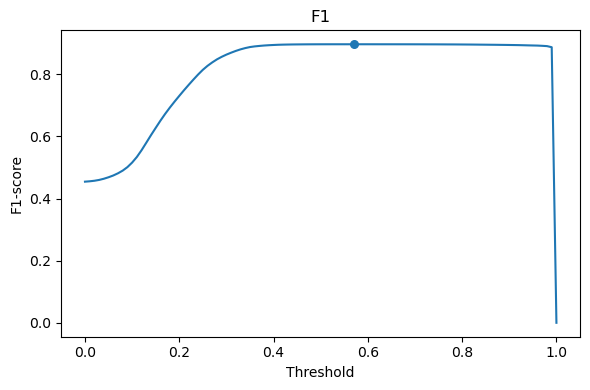

In [62]:
# Подберём оптимальный threshold

import numpy as np
from sklearn.metrics import f1_score

proba_valid = from_file.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 101)
best_thr = 0.5
best_f1 = float('-inf')

for t in thresholds:
    preds = (proba_valid >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

print(f'best F1(valid) = {best_f1:.4f} @ thr = {best_thr:.2f}')

# Построим график F1 от threshold

thr_grid = np.linspace(0, 1, 101)
f1_vals = []
for t in thr_grid:
    f1_vals.append(f1_score(y_test, (proba_valid >= t).astype(int)))
best_idx = int(np.argmax(f1_vals))
fig_f1thr = plt.figure(figsize=(6, 4))
plt.plot(thr_grid, f1_vals)
plt.scatter(thr_grid[best_idx], f1_vals[best_idx], s=30)
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1')
plt.tight_layout()
plt.show()


In [31]:
# Classification report
from sklearn.metrics import classification_report

y_pred_thr = (proba_valid >= best_thr).astype(int)
print(classification_report(y_test, y_pred_thr, digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9276    0.9999    0.9624    570016
           1     0.9997    0.8126    0.8965    237226

    accuracy                         0.9449    807242
   macro avg     0.9637    0.9063    0.9295    807242
weighted avg     0.9488    0.9449    0.9431    807242



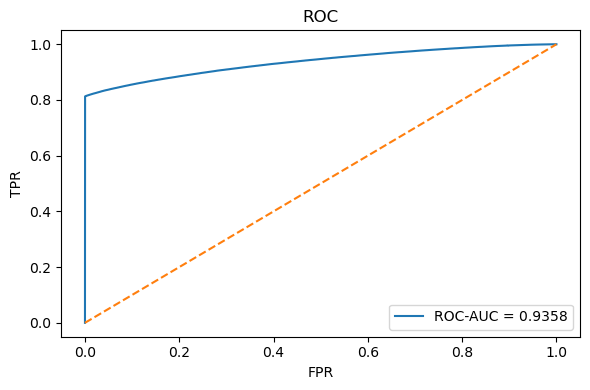

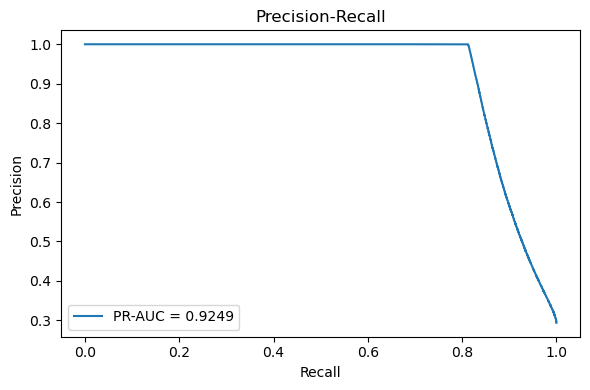

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# ROC
fpr, tpr, _ = roc_curve(y_test, proba_valid)
roc_auc = roc_auc_score(y_test, proba_valid)
fig_roc = plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PR
prec, rec, thr = precision_recall_curve(y_test, proba_valid)
pr_auc = auc(rec, prec)
fig_pr = plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f'PR-AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [33]:
fig_roc.savefig('img/roc_curve.png', dpi=150)
fig_pr.savefig('img/pr_curve.png', dpi=150)
fig_f1thr.savefig('img/f1.png', dpi=150)

## **5. Submissions**

In [39]:
X_submit = test.reindex(columns=X.columns).copy()
loan_id_submit = test['loan_id'].copy()

proba_test = from_file.predict_proba(X_submit)[:, 1]
pred_test = (proba_test >= best_thr).astype(int)

submission = pd.DataFrame({
    'loan_id': loan_id_submit,
    'churn': pred_test
})
submission.to_csv('submission.csv', index=False)

submission.head()


,loan_id,churn
0,4057275,1
1,548313,1
2,1978430,1
3,2884196,1
4,3647374,1
